# 1. **Define dependencies and constrains**

In order to download tweet from Twitter, first one must create an account and apply for **developer priviledges**. The application will grant the developer basic access the the [Twitter API](https://developer.twitter.com/en/docs/twitter-api) which are not enough because it only allows the download of tweet of the last 7 days. Therefore, I've applied to the [Premium plan](https://developer.twitter.com/en/support/twitter-api/premium) which allows the download of 25k of tweets per month along with the use _full archive_ and the _30 days_ search API but with limited amout of request per month.

In [1]:
JAVA_HOME = "/usr/lib/jvm/java-8-openjdk-amd64"
COLLAB_DIR = "/content/"

RANDOM_SEED = 42

# File with Twitter project credentials
CREDENTIALS = '/content/credentials.yaml'
CREDENTIALS_KEY = 'search_tweets_30_day_dev'

# csv file where tweet downloaded will be saved
DATASET = '/content/dataset.csv'
DATASET_ANNOTATED = '/content/dataset_annotated.csv'
SENTIPOLIC = '/content/sentipolic.csv'

In [2]:
!python --version

Python 3.7.13


### install libraries

In [3]:
!pip install findspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
!apt-get install libenchant1c2a
!pip install pyenchant
!apt-get install hunspell-it

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  aspell aspell-en dictionaries-common emacsen-common enchant hunspell-en-us
  libaspell15 libhunspell-1.6-0 libtext-iconv-perl
Suggested packages:
  aspell-doc spellutils wordlist hunspell openoffice.org-hunspell
  | openoffice.org-core libenchant-voikko
The following NEW packages will be installed:
  aspell aspell-en dictionaries-common emacsen-common enchant hunspell-en-us
  libaspell15 libenchant1c2a libhunspell-1.6-0 libtext-iconv-perl
0 upgraded, 10 newly installed, 0 to remove and 42 not upgraded.
Need to get 1,312 kB of archives.
After this operation, 5,353 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/main amd64 libtext-iconv-perl amd64 1.7-5build6 [13.0 kB

In [5]:
!apt install openjdk-8-jdk-headless -qq

import os
os.environ["JAVA_HOME"] = JAVA_HOME

The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  openjdk-8-jre-headless
Suggested packages:
  openjdk-8-demo openjdk-8-source libnss-mdns fonts-dejavu-extra
  fonts-ipafont-gothic fonts-ipafont-mincho fonts-wqy-microhei
  fonts-wqy-zenhei fonts-indic
The following NEW packages will be installed:
  openjdk-8-jdk-headless openjdk-8-jre-headless
0 upgraded, 2 newly installed, 0 to remove and 42 not upgraded.
Need to get 36.5 MB of archives.
After this operation, 143 MB of additional disk space will be used.
Selecting previously unselected package openjdk-8-jre-headless:amd64.
(Reading database ... 156050 files and directories currently installed.)
Preparing to unpack .../openjdk-8-jre-headless_8u312-b07-0ubuntu1~18.04_amd64.deb ...
Unpacking openjdk-8-jre-headless:amd64 (8u312-b07-0ubuntu1~18.04) ...
Selecting previously unselected package openjdk-8-

In [6]:
!java -version

openjdk version "11.0.15" 2022-04-19
OpenJDK Runtime Environment (build 11.0.15+10-Ubuntu-0ubuntu0.18.04.1)
OpenJDK 64-Bit Server VM (build 11.0.15+10-Ubuntu-0ubuntu0.18.04.1, mixed mode, sharing)


In [7]:
!pip install pyspark==3.2.0
!pip install spark-nlp==3.4.4

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 281.3 MB 17 kB/s 
     |████████████████████████████████| 198 kB 37.5 MB/s 
  Created wheel for pyspark: filename=pyspark-3.2.0-py2.py3-none-any.whl size=281805911 sha256=78d58367275728fd2a8f4eda180d6fb3a0b0545507fea4d3caaee96af005d9aa
  Stored in directory: /root/.cache/pip/wheels/0b/de/d2/9be5d59d7331c6c2a7c1b6d1a4f463ce107332b1ecd4e80718
Successfully built pyspark
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 145 kB 5.5 MB/s 


In [8]:
!pip install keras-tqdm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [9]:
!pip install elephas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.1 MB 7.8 MB/s 
     |████████████████████████████████| 462 kB 19.2 MB/s 
  Created wheel for elephas: filename=elephas-3.1.0-py3-none-any.whl size=26259 sha256=d12befe98537e8df57145fb98cf6407f1341ba3e44ddf00fd47124d3799e3412
  Stored in directory: /root/.cache/pip/wheels/33/e4/e1/56dda8be927bb0e9971cd7ddf3fc1b17ce78db56268b1f867f
Successfully built elephas
  Attempting uninstall: h5py
    Found existing installation: h5py 3.1.0
    Uninstalling h5py-3.1.0:
      Successfully uninstalled h5py-3.1.0


### import libraries

In [10]:
# pyspark packages
from pyspark import *
from pyspark.sql import *
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark import SparkContext, SparkConf
from pyspark.sql import DataFrame
from pyspark.ml.feature import VectorAssembler, SQLTransformer, Normalizer

In [11]:
# data processing useful packages
from pyspark.sql.functions import udf, col, lower, trim, regexp_replace, transform
import enchant
from enchant.checker import SpellChecker

In [12]:
# libraries for feature engineering
import sparknlp
from sparknlp.base import *
from sparknlp.annotator import *
from sparknlp.common import *
from sparknlp.annotator import Tokenizer

In [13]:
# useful imports
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import requests
import json
import yaml
import csv
import pdb
import pandas as pd

In [14]:
# python widgets
from ipywidgets import Button
import asyncio
from IPython.display import display, clear_output
import ipywidgets as widgets
from ipywidgets import HBox, Layout
import time as t
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [15]:
# Kers imports
import tensorflow as tf
from keras_tqdm import TQDMNotebookCallback
from keras.layers.core import Dense, Dropout, Activation
from keras import optimizers, regularizers
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from keras.preprocessing.sequence import *

In [16]:
# keras 
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM
from keras.callbacks import ModelCheckpoint, EarlyStopping

In [17]:
# sklearn 
from sklearn.model_selection import train_test_split

In [18]:
from elephas.ml_model import ElephasEstimator

### PySpark configurations

In [19]:
spark = sparknlp.start(spark32=True)

print("Spark NLP version", sparknlp.version())
print("Apache Spark version:", spark.version)

Spark NLP version 3.4.4
Apache Spark version: 3.2.0


In [20]:
sc = spark.sparkContext
type(sc)

pyspark.context.SparkContext

In [21]:
import findspark
findspark.init()

In [22]:
! cd ~/.ivy2/cache/com.johnsnowlabs.nlp/spark-nlp_2.12/jars && ls -lt

/bin/bash: line 0: cd: /root/.ivy2/cache/com.johnsnowlabs.nlp/spark-nlp_2.12/jars: No such file or directory


## Download Files from GitHub

In [23]:
!wget https://github.com/deborahdore/italian-sarcastic-tweet-classification/raw/main/dataset/dataset.csv
!wget https://github.com/deborahdore/italian-sarcastic-tweet-classification/raw/main/dataset/other/sentipolic.csv
!wget https://raw.githubusercontent.com/deborahdore/italian-sarcastic-tweet-classification/main/credentials/credentials.yaml
!wget https://raw.githubusercontent.com/deborahdore/italian-sarcastic-tweet-classification/main/dataset/dataset_annotated.csv

--2022-05-23 21:55:53--  https://github.com/deborahdore/italian-sarcastic-tweet-classification/raw/main/dataset/dataset.csv
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/deborahdore/italian-sarcastic-tweet-classification/main/dataset/dataset.csv [following]
--2022-05-23 21:55:54--  https://raw.githubusercontent.com/deborahdore/italian-sarcastic-tweet-classification/main/dataset/dataset.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1797205 (1.7M) [text/plain]
Saving to: ‘dataset.csv’

dataset.csv         100%[===================>]   1.71M  --.-KB/s    in 0.06s   

2022-05-23 21:55:54 (31.

In [24]:
# italian dictionary for lemmatization
!wget https://raw.githubusercontent.com/michmech/lemmatization-lists/master/lemmatization-it.txt

--2022-05-23 21:55:56--  https://raw.githubusercontent.com/michmech/lemmatization-lists/master/lemmatization-it.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7917510 (7.5M) [text/plain]
Saving to: ‘lemmatization-it.txt’

lemmatization-it.tx 100%[===================>]   7.55M  --.-KB/s    in 0.08s   

2022-05-23 21:55:56 (90.0 MB/s) - ‘lemmatization-it.txt’ saved [7917510/7917510]



# 2. **Retrieve Tweet**


> Following, some code cell will be annotated with *%% script false* in order to avoid their execution. Those cell concern the download of the tweets from Twitter. Even if this may not sound dangerous, I've finished the request at my disposal. Therefore, calling the Twitter API will produce an error. Also, please don't run them otherwise the output of the cell will be lost.



- First we must retrieve and validate the credentials that we will need to access the Twitter API. I've store the bearer token in a yaml file: *credentials.yaml*





In [25]:
def handle_credentials(credentials, key):
  with open(credentials, "r") as stream:
    try:
        credentials = yaml.safe_load(stream)
        return credentials[key]
    except yaml.YAMLError as exc:
        print(exc)

In [26]:
credentials = handle_credentials(CREDENTIALS, CREDENTIALS_KEY)
endpoint = credentials['endpoint'] # we will use this endpoint to search for the tweet
print(endpoint)

https://api.twitter.com/1.1/tweets/search/30day/dev1.json


- Second we must create the header for the request

In [27]:
def handle_headers(credentials:dict):
  headers = {
    'Content-Type': 'application/json',
    'Authorization': f'Bearer {credentials["bearer_token"]}'
  }
  return headers

In [28]:
headers = handle_headers(credentials)
headers

{'Authorization': 'Bearer None', 'Content-Type': 'application/json'}

- Another parameter of the request is the query. The query determines which tweet will be returned in the response. In our case, we have 2 types of queries: the one that searches for sarcastic tweets and the one that returns non-sarcastic tweets

For the query about sarcastic tweet I've chosen some keyword that, in my opion, are used to express sarcasm and/or irony (sarcasm is a sub-type of irony):


1. sarcasmo (with or without #)
2. ironia (with or without #)
3. "*ridiamo per non piangere*"
4. #coincidenze (.. io non credo) is mostly used to express sarcasm
5. "*qualquadra non cosa*"

Many studies also suggest that sarcasm can be found in tweet related to politics. Therefore, these seems very good starting point:
1. monti, draghi, berlusconi (known italian prime minister)
2. governo
3. premier


For non-sarcastic tweet, I've excluded all the possibile word that may refer to sarcasm.

The list of operator used can be found in the [Twitter API documentation](https://developer.twitter.com/en/docs/twitter-api/enterprise/rules-and-filtering/operators-by-product).

In [29]:
sarcasm_query = '(#sarcasmo OR sarcasmo OR #ironia OR ironia OR "ridiamo per non piangere" \
                  OR #coincidenze OR "qualquadra non cosa" OR draghi OR monti OR berlusconi \
                  OR governo OR premier) lang:it -has:media'

non_sarcasm_query = '-"ridiamo per non piangere" -sarcasmo -ironia -"qualquadra non cosa" lang:it -has:media'

- Now we can define the function that will handle the request and the dataframe where tweet will be stored.


> Other parameters that we need in order to process the request are:
- *max_result_per_page* : the maximum number of tweets per call 
- *next_token* : a token that if passed to the request will return the next page of results
- I've defined a parameter *max_num_of_request* that will stop the call once that we've reached the desidered amount of calls. This must be done because the request at our disposal are not illimited. So we must be careful to the number of the request that we do




In [30]:
def handle_request(endpoint, headers, query, max_result_per_page, next_token = None):
  
  if next_token is not None:
    payload = json.dumps({
      "maxResults": max_result_per_page,
      "query": query,
      "next": next_token
    })
  else:
    payload = json.dumps({
      "maxResults": max_result_per_page,
      "query": query,
    })
  
  response = requests.post(endpoint, headers=headers, data=payload)

  return response.text

In [31]:
def extract_tweet(response, label):
  tweets = []
  json_response = json.loads(response)
  
  if 'results' in response:
    results = json_response["results"]

    for tweet in results:
      # is tweet a retweet?
      if 'retweeted_status' in tweet:
        if tweet['retweeted_status']['truncated']:
          text = tweet['retweeted_status']['extended_tweet']['full_text']
        else:
          text = tweet['retweeted_status']['text']
      else:
        if tweet['truncated']:
          text = tweet['extended_tweet']['full_text']
        else:
          text = tweet['text']
        
      text = text.replace('"', "'")
      data = Tweet(tweet["id"], f"{text}", label)
      
      tweets.append(data)

  else:
    print("Request went wrong")
    print(response)

  return tweets

In [32]:
def download_tweet(endpoint, 
                   headers, 
                   query, 
                   label,
                   max_result_per_page,
                   tweet_list,
                   next_token = None, 
                   max_num_of_request = 20):

  if max_num_of_request <= 0:
    return tweet_list

  response = handle_request(endpoint, headers, query, max_result_per_page, next_token)

  tweet_list.extend(extract_tweet(response, label))

  try:
      next_token = json.loads(response)['next']
  except:
      next_token = None

  if next_token is not None:
      return download_tweet(endpoint, headers, query, label, max_result_per_page,
                   tweet_list, next_token, max_num_of_request - 1)
  else:
      return tweet_list

In [33]:
# define tweet
Tweet = Row("id", "text", "sarcastic")

In [34]:
tweets = []

In [35]:
%%script false

# download sarcastic tweet
tweets = download_tweet(endpoint, 
                   headers, 
                   sarcasm_query, 
                   "Yes",
                   100,
                   [],
                   next_token = None, 
                   max_num_of_request = 40)

In [36]:
%%script false

# download non-sarcastic tweet
tweets.extend(
    download_tweet(endpoint, 
                   headers, 
                   non_sarcasm_query, 
                   "No",
                   100,
                   [],
                   next_token = None, 
                   max_num_of_request = 40))

In [37]:
%%script false
# create DataFrame
df = spark.createDataFrame(tweets)

In [38]:
%%script false
df.show(10, truncate=False)

In [39]:
%%script false

# create file
if not os.path.exists(DATASET):
  os.mknod(DATASET)

# save tweets
df.toPandas().to_csv(DATASET, header=True, index=False) 

# 3. **Annotate Tweet**

When we download tweet using an hashtag, we are not 100% sure of what we downloaded is correct. We must analyze - at least - the majority of the tweet to understand if what we have labelled is correct. There here's a little tool to help us with that.

In [40]:
Tweet = Row("id", "text", "sarcastic")

schema = StructType([StructField("id", StringType(), True)\
                   ,StructField("text", StringType(), True)\
                   ,StructField("sarcastic", StringType(), True)])

df = spark.createDataFrame(pd.read_csv(DATASET), schema=schema)
df.show(10)

+-------------------+--------------------+---------+
|                 id|                text|sarcastic|
+-------------------+--------------------+---------+
|1524034279151489025|@AlienoGentile C’...|       No|
|1524034279122034690|@NaremFox @RickyT...|       No|
|1524034278983704581|Sempre al fine di...|       No|
|1524034278870372354|E Comunque quest'...|       No|
|1524034278828425218|Comunque a me Alb...|       No|
|1524034278719475712|che bella persona...|       No|
|1524034278589411328|oddio io quando h...|       No|
|1524034278559993857|@carlopitocchi La...|       No|
|1524034278140616708|Oh nooo solo 400 ...|       No|
|1524034278031609856|@WillSorareSmith ...|       No|
+-------------------+--------------------+---------+
only showing top 10 rows



In [41]:
def count_label(df, numeric=False):
  label_yes = 1 if numeric else "Yes"
  label_no = 0 if numeric else "No"
  return df.groupBy("sarcastic").agg(
      count(when(col("sarcastic") == label_yes, 1)),
      count(when(col("sarcastic") == label_no, 1)))

In [42]:
# count tweet
print(f'Total number of tweet retrieved {df.count()}')

Total number of tweet retrieved 11800


In [43]:
# we want first to drop duplicates

print("Count before drop:")
count_label(df).show()

count_before_drop = df.count()
df = df.dropDuplicates(["text"])
print(f"Distinct count: {str(df.count())} \n")

print("Count after drop:")
count_label(df).show()

Count before drop:
+---------+---------------------------------------------+--------------------------------------------+
|sarcastic|count(CASE WHEN (sarcastic = Yes) THEN 1 END)|count(CASE WHEN (sarcastic = No) THEN 1 END)|
+---------+---------------------------------------------+--------------------------------------------+
|       No|                                            0|                                        7800|
|      Yes|                                         4000|                                           0|
+---------+---------------------------------------------+--------------------------------------------+

Distinct count: 9290 

Count after drop:
+---------+---------------------------------------------+--------------------------------------------+
|sarcastic|count(CASE WHEN (sarcastic = Yes) THEN 1 END)|count(CASE WHEN (sarcastic = No) THEN 1 END)|
+---------+---------------------------------------------+--------------------------------------------+
|       No| 

In [44]:
print(f'dropped {count_before_drop-df.count()} columns')
print(f'total count: {df.count()}')

dropped 2510 columns
total count: 9290


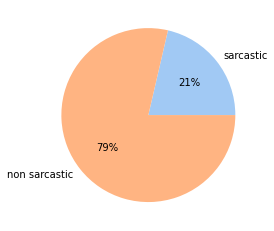

In [45]:
# visually 
data = count_label(df).collect()

labels = ['sarcastic', 'non sarcastic']
colors = sns.color_palette('pastel')[0:5]

plt.pie([int(data[1][1]), int(data[0][2])], labels = labels, colors = colors, autopct='%.0f%%')
plt.show()

In [46]:
tweets_annotated = []

In [47]:
def wait_for_change(widget1, widget2): 
    future = asyncio.Future()
    def getvalue(change):
        future.set_result(change.description)
        widget1.on_click(getvalue, remove=True)
        widget2.on_click(getvalue, remove=True) 
    widget1.on_click(getvalue)
    widget2.on_click(getvalue)
    return future

async def f(df):
  df_pandas = df.toPandas()
  for index, row in df_pandas.iterrows():
    print(f'Is this tweet sarcastic? \n {row.text} \n', flush=True)

    x = await wait_for_change(sarcastic,non_sarcastic)
    
    if x == "Yes":
      print("Tagged ", row.id, "with sarcastic \n")
      data = Tweet(row.id, row.text, "Yes")
      tweets_annotated.append(data)
    else:
      print("Tagged ", row.id, "with non-sarcastic \n")
      data = Tweet(row.id, row.text, "No")      
      tweets_annotated.append(data)

    clear_output()
    display(HBox([sarcastic,non_sarcastic]))

Before going forward, we want to ask ourselves *How can know if a tweet is sarcastic or not?*

*In Harry Potter and the Half Blood Prince, there is a scene where Harry is leaving the Weasley house and Mrs. Weasley says: “Promise me you will look after yourself…stay out of trouble….” Harry responds: “I always do Mrs. Weasley. I like a quiet life, you know me.” Anyone familiar with Harry Potter knows that his life is far from quiet, and so he must not really mean what he is saying. In fact, Harry is being sarcastic.*

[source](https://kids.frontiersin.org/articles/10.3389/frym.2018.00056)

Sarcasm is the use of words that say the opposite of what you really mean, often as a joke and with a tone of voice that shows this. It is often used to mock or critize someone, express disapproval or as a defence mechanism.

For example:
> *Noi invece ce la caviamo con un grado in meno ai termosifoni d'inverno e spegnendo i condizionatori d'estate. Non è fantastico? (#Draghi è un cialtrone sesquipedale, nel caso aveste ancora qualche dubbio)*

Here we can imagine the sarcastic tone of the writer. He's obviously criticising the Italian prime minister, Mario Draghi, when, during an interview, he said that we must make sacrifices like lowering the grade of the radiator in order to cope with the possibility of not having the gas from Russia anymore. Obviously, this won't be enough. *Isn't this great?*

Sometimes it's difficult also for a human person to understand sarcasm therefore I don't expect the following dataset to be 100% free from bias.

In [48]:
# tool used for annotation: it displays each tweet and the user has to click "Yes" 
# if the tweet was sarcastic, "No" otherwise

sarcastic=Button(description="Yes", button_style='info', layout=Layout(width='150px', height='50px'))
non_sarcastic=Button(description="No", button_style='info', layout=Layout(width='150px', height='50px'))

asyncio.create_task(f(df))
t.sleep(2)
display(HBox([sarcastic,non_sarcastic]))

In [49]:
%%script false
print(tweets_annotated)

In [50]:
%%script false
df_annotated = spark.createDataFrame(tweets_annotated)
df_annotated.tail(5)

In [51]:
%%script false
if not os.path.exists(DATASET_ANNOTATED):
  os.mknod(DATASET_ANNOTATED)

# save tweets
df_annotated.toPandas().to_csv(DATASET_ANNOTATED, header=True, index=False) 

# 4. **Extend Dataset**

In [52]:
schema = StructType([StructField("id", StringType(), True)\
                   ,StructField("text", StringType(), True)\
                   ,StructField("sarcastic", StringType(), True)])

df_annotated = spark.createDataFrame(pd.read_csv(DATASET_ANNOTATED), schema=schema)

In [53]:
print(f"Annotated tweets: {df_annotated.count()}")

Annotated tweets: 5480


As we can see from the code below, we lost multiple *tweet*.
First of all, multiple tweets classified as sarcastic were not sarcastic. Also, I've dropped every tweet that contained only one word, that wasn't actually in italian or 
that had no sense.

In [54]:
count_label(df_annotated).show()

+---------+---------------------------------------------+--------------------------------------------+
|sarcastic|count(CASE WHEN (sarcastic = Yes) THEN 1 END)|count(CASE WHEN (sarcastic = No) THEN 1 END)|
+---------+---------------------------------------------+--------------------------------------------+
|       No|                                            0|                                        4629|
|      Yes|                                          830|                                           0|
|      NaN|                                            0|                                           0|
+---------+---------------------------------------------+--------------------------------------------+



However, we can integrate we some external Dataset such as: [SENTIPOLIC](http://www.di.unito.it/~tutreeb/sentipolc-evalita16/index.html) from the challenge EVALITA2016 which contains several italian tweet already classified.

In [55]:
df_sentipolic = spark.createDataFrame(pd.read_csv(SENTIPOLIC))

In [56]:
df_sentipolic.show(10)

+------------------+----+----+----+---+----+----+---+--------------------+
|         idtwitter|subj|opos|oneg|iro|lpos|lneg|top|                text|
+------------------+----+----+----+---+----+----+---+--------------------+
|122449983151669248|   1|   0|   1|  0|   0|   1|  1|Intanto la partit...|
|125485104863780865|   1|   0|   1|  0|   0|   1|  1|False illusioni, ...|
|125513454315507712|   1|   0|   1|  0|   0|   1|  1|False illusioni, ...|
|125524238290522113|   1|   0|   1|  0|   0|   1|  1|Mario Monti: Berl...|
|125527933224886272|   1|   0|   1|  0|   0|   1|  1|Mario Monti: Berl...|
|125530285164072961|   1|   1|   1|  0|   1|   1|  1|False illusioni, ...|
|125533343482789889|   1|   0|   1|  0|   0|   1|  1|L'attacco di Mari...|
|125633929217708032|   1|   1|   0|  0|   1|   0|  1|Mario Monti sul C...|
|125642756147265536|   1|   0|   1|  0|   0|   1|  1|Le 5 sgradevoli r...|
|125692702145785856|   1|   0|   1|  0|   0|   1|  1|False illusioni, ...|
+------------------+----+

In [57]:
# we will extract only the tweets which are ironic since we have plenty non-ironic
df_sentipolic = df_sentipolic.filter(col("iro")==1)

In [58]:
print(f"Ironic tweet retrieved: {df_sentipolic.count()}")

Ironic tweet retrieved: 1103


In [59]:
# drop columns that we don't need
df_sentipolic = df_sentipolic.drop(*('subj', 'opos', 'oneg', 'lpos', 'lneg', 'top'))

# rename columns
df_sentipolic = df_sentipolic.withColumnRenamed("idTwitter", "id")\
                              .withColumnRenamed("iro", "sarcastic")

# change order
df_sentipolic = df_sentipolic.select("id", "text", "sarcastic")

In [60]:
df_sentipolic.show(10)

+------------------+--------------------+---------+
|                id|                text|sarcastic|
+------------------+--------------------+---------+
|125695266887184384|Mario Monti: c'è ...|        1|
|125838624670490624|Ma a quanta gente...|        1|
|127137847491821568|#la7 ma perche' M...|        1|
|129143970163990528|Mario Monti è con...|        1|
|131426878245437440|Ma quanto ce vuol...|        1|
|133822129773879297|Mario Monti a cap...|        1|
|133831591234502656| Mario Monti for ...|        1|
|133849038243110912|[News] Mario Mont...|        1|
|133954931982991360|cmq Mario Monti è...|        1|
|134335814531416064| Napolitano: "Bis...|        1|
+------------------+--------------------+---------+
only showing top 10 rows



In [61]:
# now we want to join the two dataset. However we must use the same label for both.
# Therefore if the tweet is sarcastic, the label will be 1, 0 otherwise.


df_annotated = df_annotated.withColumn("sarcastic", 
                                         when(df_annotated.sarcastic == "Yes", 1)
                                         .when(df_annotated.sarcastic == "No", 0)                                    
                                         .otherwise(df_annotated.sarcastic))

In [62]:
df_annotated.show()

+-------------------+--------------------+---------+
|                 id|                text|sarcastic|
+-------------------+--------------------+---------+
|1524033834416754689|#'Tu sei un gioca...|        0|
|1524034020417294337|#10maggio In occa...|        0|
|1524034242963034112|#9maggio Zelensky...|        0|
|1524034526908981250|#A SCUOLA DI GIUS...|        1|
|1524034207923814401|#A1 - Ginevra -&g...|        0|
|1524034530579030018|#A1 - Zurigo -&gt...|        0|
|1524034404850581504|#APRILIA: TENTATO...|        0|
|1524034635012968448|#Agricoltura, Ocm...|        0|
|1524034097424777216|#Algeria: colloqu...|        0|
|1524034794635603972|#Alpini pensate c...|        1|
|1524034897383505921|#Amici21\nIl mond...|        0|
|1524034689366953984|#Amici21\nRiassun...|        0|
|1524034761940946952|#Amici21 che tene...|        0|
|1523988570867961856|#Armi #Ucraina Fr...|        1|
|1524001659290017794|#Armi, #gas e nuo...|        1|
|1524033774102720512|#Aron è una creat...|    

In [63]:
# concatenate DataFrames

df_complete = df_annotated.union(df_sentipolic)
df_complete.show(5)

+-------------------+--------------------+---------+
|                 id|                text|sarcastic|
+-------------------+--------------------+---------+
|1524033834416754689|#'Tu sei un gioca...|        0|
|1524034020417294337|#10maggio In occa...|        0|
|1524034242963034112|#9maggio Zelensky...|        0|
|1524034526908981250|#A SCUOLA DI GIUS...|        1|
|1524034207923814401|#A1 - Ginevra -&g...|        0|
+-------------------+--------------------+---------+
only showing top 5 rows



In [64]:
print(f'Now we have a total of {df_complete.count()} tweets')

Now we have a total of 6583 tweets


In [65]:
count_label(df_complete, numeric=True).show()

+---------+-------------------------------------------+-------------------------------------------+
|sarcastic|count(CASE WHEN (sarcastic = 1) THEN 1 END)|count(CASE WHEN (sarcastic = 0) THEN 1 END)|
+---------+-------------------------------------------+-------------------------------------------+
|        0|                                          0|                                       4629|
|      NaN|                                          0|                                          0|
|        1|                                       1933|                                          0|
+---------+-------------------------------------------+-------------------------------------------+



The dataset is still unbalanced, but better than before.

# 5. **Data Processing**

First we want to clean tweet: remove hashtag, links, emoji, whitespaces, mentions.

### Convert to lowercase

In [66]:
df_lowercase = df_complete.withColumn('text', lower(col('text')))
df_lowercase.show(5)

+-------------------+--------------------+---------+
|                 id|                text|sarcastic|
+-------------------+--------------------+---------+
|1524033834416754689|#'tu sei un gioca...|        0|
|1524034020417294337|#10maggio in occa...|        0|
|1524034242963034112|#9maggio zelensky...|        0|
|1524034526908981250|#a scuola di gius...|        1|
|1524034207923814401|#a1 - ginevra -&g...|        0|
+-------------------+--------------------+---------+
only showing top 5 rows



### Remove Links

In [67]:
df_links = df_lowercase.withColumn('text', regexp_replace('text', r'http\S+', ''))
df_links.show(5)

+-------------------+--------------------+---------+
|                 id|                text|sarcastic|
+-------------------+--------------------+---------+
|1524033834416754689|#'tu sei un gioca...|        0|
|1524034020417294337|#10maggio in occa...|        0|
|1524034242963034112|#9maggio zelensky...|        0|
|1524034526908981250|#a scuola di gius...|        1|
|1524034207923814401|#a1 - ginevra -&g...|        0|
+-------------------+--------------------+---------+
only showing top 5 rows



### Remove mentions

In [68]:
df_mentions = df_links.withColumn('text', regexp_replace('text', '@\w+', ''))
df_mentions.show(5)

+-------------------+--------------------+---------+
|                 id|                text|sarcastic|
+-------------------+--------------------+---------+
|1524033834416754689|#'tu sei un gioca...|        0|
|1524034020417294337|#10maggio in occa...|        0|
|1524034242963034112|#9maggio zelensky...|        0|
|1524034526908981250|#a scuola di gius...|        1|
|1524034207923814401|#a1 - ginevra -&g...|        0|
+-------------------+--------------------+---------+
only showing top 5 rows



### Remove hashtag, keeping the word

In [69]:
df_hashtag = df_mentions.withColumn('text', regexp_replace('text', '#', ''))
df_hashtag.show(5)

+-------------------+--------------------+---------+
|                 id|                text|sarcastic|
+-------------------+--------------------+---------+
|1524033834416754689|'tu sei un giocat...|        0|
|1524034020417294337|10maggio in occas...|        0|
|1524034242963034112|9maggio zelensky?...|        0|
|1524034526908981250|a scuola di giuse...|        1|
|1524034207923814401|a1 - ginevra -&gt...|        0|
+-------------------+--------------------+---------+
only showing top 5 rows



### Remove RT symbol

In [70]:
df_RT = df_hashtag.withColumn('text', regexp_replace('text', 'RT', ''))
df_RT.show(5)

+-------------------+--------------------+---------+
|                 id|                text|sarcastic|
+-------------------+--------------------+---------+
|1524033834416754689|'tu sei un giocat...|        0|
|1524034020417294337|10maggio in occas...|        0|
|1524034242963034112|9maggio zelensky?...|        0|
|1524034526908981250|a scuola di giuse...|        1|
|1524034207923814401|a1 - ginevra -&gt...|        0|
+-------------------+--------------------+---------+
only showing top 5 rows



### Remove punctuation

In [71]:
df_punctuation = df_RT.withColumn('text', regexp_replace('text', '[^a-zA-Z\\s]', ''))
df_punctuation.show(5)

+-------------------+--------------------+---------+
|                 id|                text|sarcastic|
+-------------------+--------------------+---------+
|1524033834416754689|tu sei un giocato...|        0|
|1524034020417294337|maggio in occasio...|        0|
|1524034242963034112|maggio zelensky n...|        0|
|1524034526908981250|a scuola di giuse...|        1|
|1524034207923814401|a  ginevra gt los...|        0|
+-------------------+--------------------+---------+
only showing top 5 rows



### Remove new line symbol

In [72]:
df_new_line = df_punctuation.withColumn('text', regexp_replace('text', '\n', ''))
df_new_line.show(5)

+-------------------+--------------------+---------+
|                 id|                text|sarcastic|
+-------------------+--------------------+---------+
|1524033834416754689|tu sei un giocato...|        0|
|1524034020417294337|maggio in occasio...|        0|
|1524034242963034112|maggio zelensky n...|        0|
|1524034526908981250|a scuola di giuse...|        1|
|1524034207923814401|a  ginevra gt los...|        0|
+-------------------+--------------------+---------+
only showing top 5 rows



### Remove emoij

In [73]:
df_emoij = df_new_line.withColumn('text', regexp_replace('text', "[^\x00-\x7F]+" , ''))
df_emoij.show(5)

+-------------------+--------------------+---------+
|                 id|                text|sarcastic|
+-------------------+--------------------+---------+
|1524033834416754689|tu sei un giocato...|        0|
|1524034020417294337|maggio in occasio...|        0|
|1524034242963034112|maggio zelensky n...|        0|
|1524034526908981250|a scuola di giuse...|        1|
|1524034207923814401|a  ginevra gt los...|        0|
+-------------------+--------------------+---------+
only showing top 5 rows



### Remove Digits

In [74]:
df_digit = df_emoij.withColumn('text', regexp_replace('text', r'[0-9]{5,}', ''))
df_digit.show(5)

+-------------------+--------------------+---------+
|                 id|                text|sarcastic|
+-------------------+--------------------+---------+
|1524033834416754689|tu sei un giocato...|        0|
|1524034020417294337|maggio in occasio...|        0|
|1524034242963034112|maggio zelensky n...|        0|
|1524034526908981250|a scuola di giuse...|        1|
|1524034207923814401|a  ginevra gt los...|        0|
+-------------------+--------------------+---------+
only showing top 5 rows



### Spell Checker

When annotating the tweets, I've noticed that many of them contained spelling errors. It is recommended to adjust those tweets before the model training.

In [75]:
broker = enchant.Broker()
broker.describe()
broker.list_languages()

['it_IT', 'en_US', 'it_CH', 'en', 'en_AU', 'en_CA', 'en_GB']

In [76]:
def spell_checker(text):
  checker = SpellChecker("it_IT", text)
  for err in checker:
    if len(err.suggest())>0:
      sug = err.suggest()[0]
      err.replace(sug)
  return checker.get_text()

In [77]:
## TODO
udf_spell_checker = udf(lambda x: (x), StringType())
df_spell = df_digit.withColumn('text', udf_spell_checker(col('text')))

df_spell.cache()

df_spell.show(5)

+-------------------+--------------------+---------+
|                 id|                text|sarcastic|
+-------------------+--------------------+---------+
|1524033834416754689|tu sei un giocato...|        0|
|1524034020417294337|maggio in occasio...|        0|
|1524034242963034112|maggio zelensky n...|        0|
|1524034526908981250|a scuola di giuse...|        1|
|1524034207923814401|a  ginevra gt los...|        0|
+-------------------+--------------------+---------+
only showing top 5 rows



### Removing exceeding whitespace

In [78]:
print("a. Trimming")
df_trimming = df_spell.withColumn('text', trim(col('text')))
df_trimming.show(5, truncate=False)

print("b. Filter out extra whitespaces")
df_cleaned = df_trimming.withColumn('text', regexp_replace(col("text"), " +", " "))

df_cleaned.show(5, truncate=False)

a. Trimming
+-------------------+------------------------------------------------------------------------------------------------------------------------------------+---------+
|id                 |text                                                                                                                                |sarcastic|
+-------------------+------------------------------------------------------------------------------------------------------------------------------------+---------+
|1524033834416754689|tu sei un giocatore incredibile abbracciami lemozionante discorso di un bambino al compagno dibattito attualitesociet la politica   |0        |
|1524034020417294337|maggio in occasione della ix giornata dellamicizia tra copti e cattolici messaggio inviato oggi da papafrancesco a tawadros ii leggi|0        |
|1524034242963034112|maggio zelensky nato crimea pace ha dettonoha rispostonograzie a  per il servizio reso alla chiarezza dei fatti                     |0        

## Result

In [79]:
df = df_cleaned.select([col('text'), col('sarcastic')])

df.cache()
df.show(5, truncate=False)

df_spell.unpersist()

+------------------------------------------------------------------------------------------------------------------------------------+---------+
|text                                                                                                                                |sarcastic|
+------------------------------------------------------------------------------------------------------------------------------------+---------+
|tu sei un giocatore incredibile abbracciami lemozionante discorso di un bambino al compagno dibattito attualitesociet la politica   |0        |
|maggio in occasione della ix giornata dellamicizia tra copti e cattolici messaggio inviato oggi da papafrancesco a tawadros ii leggi|0        |
|maggio zelensky nato crimea pace ha dettonoha rispostonograzie a per il servizio reso alla chiarezza dei fatti                      |0        |
|a scuola di giuseppe conte devi venire                                                                                           

DataFrame[id: string, text: string, sarcastic: string]

# 6. **Feature Engineering**

In [80]:
print("Starting feature engineering, constructing pipeline..")

Starting feature engineering, constructing pipeline..


## Document assembler
Each annotator in Spark NLP takes specific sorts of columns and produces new columns of a different type. We have the following types in Spark NLP: document, token, chunk, pos, word embeddings, date, entity, sentiment, named entity, dependency, labeled dependency.

To implement the solution in Spark NLP, we must first transform raw data into Document type. DocumentAssembler() is a special transformer that builds the initial annotation of type Document that annotators can utilize later on.

In [81]:
document_assembler = DocumentAssembler()\
                        .setInputCol('text')\
                        .setOutputCol('document')\
                        .setCleanupMode("shrink")

## Sentence Detector
Finds sentence bounds in raw text.

In [82]:
sentence_detector = SentenceDetector()\
                      .setInputCols('document')\
                      .setOutputCol('sentence')

## Tokenizer
Tokenization is the process of breaking raw text into smaller pieces. Tokenization divides the raw text into words known as tokens. These tokens help to better understand the context or constructing the NLP model. Tokenization aids in determining the meaning of the text by evaluating the word sequence.

In [83]:
tokenizer = sparknlp.annotator.Tokenizer().setInputCols(["sentence"]).setOutputCol("token")

## Lemmatizer
Lemmatization is a technique for reducing words to their normalized form. The transformation of lemmatization employs a dictionary to map distinct versions of a word back to its base format. So, using this method, we may reduce non-trivial inflections like "is," "was," and "were" down to the root "be."

In [84]:
lemma = Lemmatizer()\
     .setInputCols(['token'])\
     .setOutputCol('lemma')\
     .setDictionary("lemmatization-it.txt", "->", "\t")

## Stopwords cleaner
Removes stopwords, that are not useful to our goal, from the text.

In [85]:
stopwords_cleaner = StopWordsCleaner.pretrained("stopwords_it", "it")\
     .setInputCols(['lemma'])\
     .setOutputCol('clean_lemma')

stopwords_it download started this may take some time.
Approximate size to download 2.4 KB
[OK!]


## Word Embedding using BERT pretrained for italian language
Word Embedding is a method that involves representing a word with a vector. The BERT model was used to construct these embeddings in the code below since it provides embeddings that allow us to have numerous vector representations for the same word dependent on the context in which the word is used. BERT embeddings are thus context-dependent.

In [86]:
embeddings = BertEmbeddings.pretrained("bert_base_italian_cased", "it") \
      .setInputCols(["sentence", "clean_lemma"]) \
      .setOutputCol("embeddings")

bert_base_italian_cased download started this may take some time.
Approximate size to download 393.1 MB
[OK!]


In [87]:
sentence_embeddings = SentenceEmbeddings()\
                        .setInputCols(["sentence", "embeddings"])\
                        .setOutputCol("sentence_embeddings")

In [88]:
embeddings_finisher = EmbeddingsFinisher() \
                      .setInputCols("sentence_embeddings") \
                      .setOutputCols("features") \
                      .setOutputAsVector(False) \
                      .setCleanAnnotations(False)

## Fitting pipeline

In [89]:
pipeline = Pipeline(stages=[
                    document_assembler,
                    sentence_detector,
                    tokenizer,
                    lemma,
                    stopwords_cleaner,
                    embeddings,
                    sentence_embeddings,
                    embeddings_finisher]
)

In [90]:
%%time
features = pipeline.fit(df).transform(df)

CPU times: user 168 ms, sys: 23.9 ms, total: 191 ms
Wall time: 3.07 s


In [91]:
df_fitted = features.withColumn("features", explode("features"))

In [95]:
%%time
df_fitted.cache()

df_fitted = df_fitted.select([col("features"), col("sarcastic").alias("target")])

df_fitted.show()

KeyboardInterrupt: ignored

# Training the model

In [93]:
rows = []
for row in df_fitted.collect():
  if len(row['features']) > 0:
    rows.append(row)

df_fitted = spark.createDataFrame(rows)

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/pyspark/sql/dataframe.py", line 693, in collect
    sock_info = self._jdf.collectToPython()
  File "/usr/local/lib/python3.7/dist-packages/py4j/java_gateway.py", line 1308, in __call__
    answer = self.gateway_client.send_command(command)
  File "/usr/local/lib/python3.7/dist-packages/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
  File "/usr/local/lib/python3.7/dist-packages/py4j/clientserver.py", line 475, in send_command
    answer = smart_decode(self.stream.readline()[:-1])
  File "/usr/lib/python3.7/socket.py", line 589, in readinto
    return self._sock.recv_into(b)
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py", line 2882, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  Fi

TypeError: ignored

In [94]:
df_fitted = df_fitted.filter(~col('target').contains('NaN'))

KeyboardInterrupt: ignored

In [ ]:
from pyspark.sql.functions import lpad
df_fitted.select('id',lpad(df_fitted['features'],250,'0')).show()

In [107]:
train, test = df_fitted.randomSplit([0.7, 0.3], seed=42)

In [155]:
input_dim = train.select('features').first()[0].shape
input_dim

(768,)

In [200]:
model = Sequential()
model.add(Embedding(300, output_dim=50))
model.add(LSTM(units=50))
model.add(Dense(1))

In [201]:
model.compile(loss='binary_crossentropy', optimizer='adam')

In [202]:
from elephas.spark_model import SparkModel

spark_model = SparkModel(model, frequency='epoch', mode='asynchronous')
spark_model.fit(train.rdd, epochs=20, batch_size=64, verbose=1, validation_split=0.1)

Py4JJavaError: ignored